In [17]:
import numpy as np
import pandas as pd
import time
import random
import os
import re
import json
import ast
import seaborn as sns
from helper_functions_assignment2 import*

# Read results from parameter tuning

In [2]:
best_configs = 'GA_smac_results.txt'
smac_runhistory = "GA_smac/4c2a6242dc8ec6ee5be9ee80d0cb33f9/0/runhistory.json"

In [3]:
# read in the file with the best configurations
with open(best_configs, 'r') as file:
    file_content = file.read()

# Extract configurations using regular expressions
config_pattern = r"Configuration\(values=\{([^}]*)\}\)"
config_values = re.findall(config_pattern, file_content)

# Convert configurations to a list of dictionaries
config_dicts = []
for config_val in config_values:
    config_dict = ast.literal_eval('{' + config_val + '}')
    config_dicts.append(config_dict)

# Convert the list of dictionaries to a DataFrame
best_configs = pd.DataFrame(config_dicts)
best_configs["best_result"] = True

In [4]:
best_configs

,MaxStallGenerations,elitism_k,init_no_plexes,mutate,pop_size,tolerance,best_result
0,5,2,13,False,80,0.016323,True
1,3,48,24,True,52,0.034970,True
2,1,40,19,False,59,0.059790,True
3,5,36,7,False,92,0.027954,True
4,3,5,25,False,89,0.062950,True
5,1,35,19,False,60,0.059860,True
6,1,36,13,False,59,0.022327,True
7,1,45,11,False,60,0.060129,True
8,1,44,11,False,60,0.021238,True
9,2,38,19,False,59,0.020278,True


In [5]:
# read in run history and transform to a data table
with open(smac_runhistory) as f:
    d = json.load(f)
print("SMAC3 stats:")
print(d["stats"])

# Extracting data and creating a DataFrame
data = d['data']
configs = d['configs']
config_origins = d['config_origins']


columns = ['Config_ID', 'Instance', 'Budget', 'Seed', 'Cost', 'Time', 'Status', 'Start_Time', 'End_Time', 'Additional Info']
runhistory = pd.DataFrame(data, columns=columns[:])

# Extracting score and runtime from the 'Costs' column
runhistory['score'] = runhistory['Cost'].apply(lambda x: x[0] if isinstance(x, list) and len(x) >= 1 else x)
runhistory['runtime'] = runhistory['Cost'].apply(lambda x: x[1] if isinstance(x, list) and len(x) >= 2 else None)


# Map config IDs to their configurations
runhistory['Config Info'] = runhistory['Config_ID'].map(lambda x: configs[str(x)])
runhistory['Config Origin'] = runhistory['Config_ID'].map(lambda x: config_origins[str(x)])

# Splitting Config Info into separate columns
config_info_columns = ['MaxStallGenerations', 'elitism_k', 'init_no_plexes', 'mutate', 'pop_size', 'tolerance']
for col in config_info_columns:
    runhistory[col] = runhistory['Config Info'].apply(lambda x: x.get(col))

# make a short version for the instance name
runhistory["Instance_ID"]=runhistory["Instance"].str[4:7]
# Rearranging columns for better visibility
runhistory = runhistory[['Config_ID', 'pop_size', 'init_no_plexes', 'mutate', 'elitism_k', 'MaxStallGenerations','tolerance',
                   "Instance_ID", 
                   'Instance', 'Budget', 'Seed', 'score', "runtime", 'Time', 
                   'Status', 'Start_Time', 'End_Time']]

SMAC3 stats:
{'submitted': 100, 'finished': 100, 'running': 0}


In [6]:
# merge with best results, so we know which are the best ones
smac_results = pd.merge(runhistory, best_configs, 
                        on = config_info_columns,
                        how = "outer").fillna(False)
# bring it in a long format so we can use facet when plotting
smac_results_long = pd.melt(smac_results, id_vars=['Config_ID', "Instance_ID", "score", "runtime", "best_result"], 
        value_vars=['pop_size', 'init_no_plexes', "mutate", "elitism_k", "MaxStallGenerations", "tolerance"])
smac_results_long

,Config_ID,Instance_ID,score,runtime,best_result,variable,value
0,1,058,8667.0,97.524179,False,pop_size,136.0
1,1,041,9084.0,687.999710,False,pop_size,136.0
2,2,041,7940.0,662.939644,True,pop_size,89.0
3,2,058,8616.0,72.434950,True,pop_size,89.0
4,2,060,23178.0,168.784443,True,pop_size,89.0
...,...,...,...,...,...,...,...
595,33,060,23823.0,66.007638,True,tolerance,0.020278
596,33,041,8077.0,294.987388,True,tolerance,0.020278
597,33,058,8498.0,36.072762,True,tolerance,0.020278
598,34,060,25575.0,46.429409,False,tolerance,0.030622


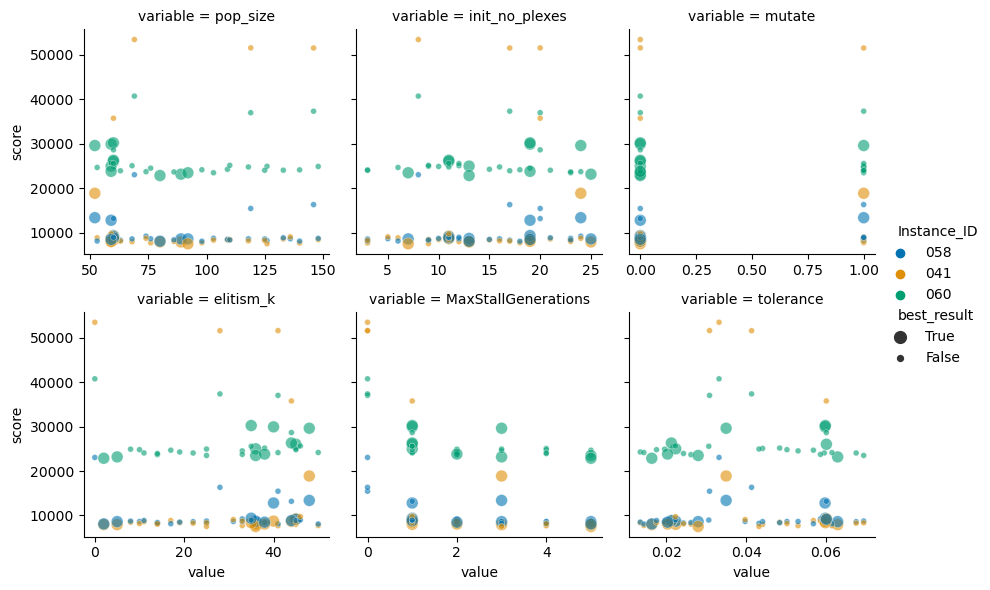

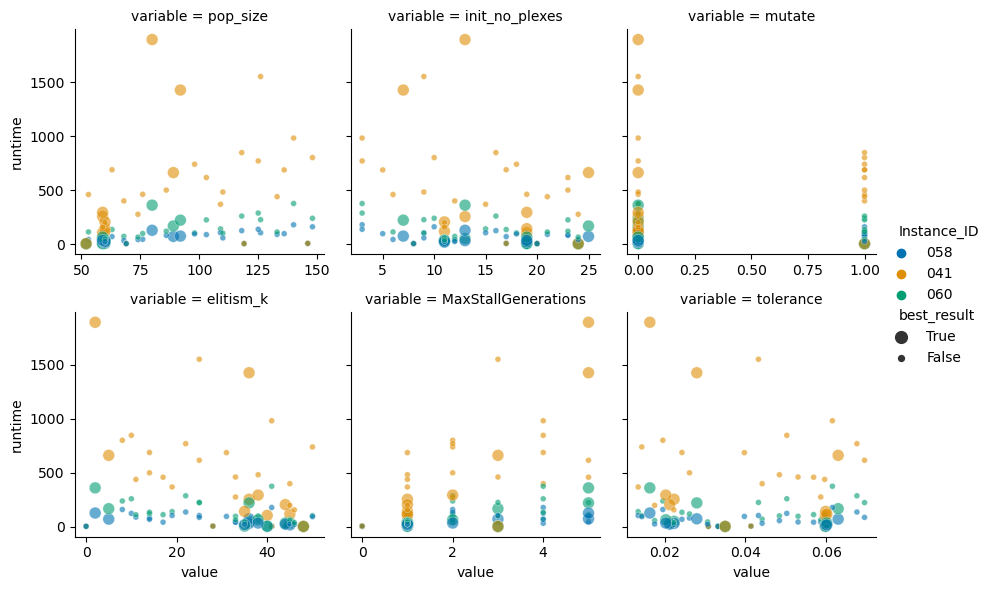

In [7]:
import warnings
warnings.filterwarnings("ignore")
# plot by score
g = sns.relplot(data=smac_results_long, x= "value", y = "score", hue='Instance_ID', size = "best_result", 
                size_order = [True, False], col = "variable", col_wrap=3, facet_kws=dict(sharex=False),
                palette= "colorblind", height = 3, alpha = 0.6)
g.fig.savefig("GA_smac_score.png")

# plot by runtime
g = sns.relplot(data=smac_results_long, x= "value", y = "runtime", hue='Instance_ID', size = "best_result", 
                size_order = [True, False], col = "variable", col_wrap=3, facet_kws=dict(sharex=False), 
                palette= "colorblind", height = 3, alpha = 0.6)
g.fig.savefig("GA_smac_runtime.png")

## pick the best configuration

In [8]:
smac_results.loc[(smac_results["Config_ID"]==33),]

,Config_ID,pop_size,init_no_plexes,mutate,elitism_k,MaxStallGenerations,tolerance,Instance_ID,Instance,Budget,Seed,score,runtime,Time,Status,Start_Time,End_Time,best_result
95,33,59,19,False,38,2,0.020278,060,heur060_n_300_m_12405,209652396,False,23823.0,66.007638,66.032070,1,1.704837e+09,1.704837e+09,True
96,33,59,19,False,38,2,0.020278,041,heur041_n_300_m_17492,209652396,False,8077.0,294.987388,295.013453,1,1.704837e+09,1.704837e+09,True
97,33,59,19,False,38,2,0.020278,058,heur058_n_300_m_4010,209652396,False,8498.0,36.072762,36.097517,1,1.704837e+09,1.704837e+09,True


# Test with best parameter settings

In [2]:
folder_path = "data/test_instances/"
problem_instances = [file.replace('.txt', '') for file in os.listdir(folder_path) if not file == "test.txt"]

In [3]:
test_results = []
for p in problem_instances:
    print(p)
    path = folder_path+p+".txt"
    node_impact_orig, node_degree_orig, plex_assignment, edges_n1, edges_n2, edge_weights, edge_assignment_orig, s, n, m = create_problem_instance(path)
    
    start = time.time()
    test, avg_traj = GA(59, 19, False, 38, 2, 0.020278, node_impact_orig, node_degree_orig, edge_assignment_orig, edge_weights, s)
    
    test_results.append({"Instance": p,
                         "result": test, 
                         "baseline": sum(node_impact_orig)/2,
                         "score": test.score, 
                         "runtime": time.time()-start,
                        "trajectory": avg_traj})
pd.DataFrame(test_results)

heur001_n_10_m_31
heur002_n_100_m_3274
heur003_n_120_m_2588
heur004_n_140_m_3014
heur005_n_160_m_4015
heur006_n_180_m_6067
heur007_n_200_m_6731
heur008_n_250_m_1045
heur009_n_250_m_1450
heur010_n_250_m_4507
heur011_n_250_m_6574
heur012_n_250_m_20035
heur013_n_250_m_22395
heur014_n_300_m_14191
heur015_n_300_m_15035
heur016_n_300_m_15456
heur017_n_300_m_15641
heur018_n_300_m_25919
heur019_n_300_m_28765
heur020_n_320_m_5905
heur021_n_320_m_13507
heur022_n_322_m_14226
heur023_n_329_m_16183
heur024_n_329_m_27115
heur025_n_329_m_32168
heur026_n_330_m_1370
heur027_n_330_m_2256
heur028_n_330_m_3253
heur029_n_330_m_4329
heur030_n_330_m_5613
heur031_n_330_m_7270
heur032_n_330_m_9770
heur033_n_330_m_13861
heur034_n_345_m_6830
heur035_n_345_m_17798
heur036_n_347_m_17983
heur037_n_347_m_31752
heur038_n_361_m_7987
heur039_n_361_m_13593


,Instance,result,baseline,score,runtime,trajectory
0,heur001_n_10_m_31,<helper_functions_assignment2.GA_solution obje...,90.0,32.0,0.179893,"[87.84745762711864, 85.16949152542372, 81.6949..."
1,heur002_n_100_m_3274,<helper_functions_assignment2.GA_solution obje...,9755.0,2112.0,14.551157,"[9380.898305084746, 9073.661016949152, 8499.71..."
2,heur003_n_120_m_2588,<helper_functions_assignment2.GA_solution obje...,7573.0,4646.0,9.704293,"[7503.254237288135, 7308.237288135593, 7074.0,..."
3,heur004_n_140_m_3014,<helper_functions_assignment2.GA_solution obje...,8987.0,6231.0,6.232181,"[8651.881355932202, 8460.203389830509, 8190.45..."
4,heur005_n_160_m_4015,<helper_functions_assignment2.GA_solution obje...,11653.0,9122.0,6.055406,"[11790.796610169491, 11457.593220338984, 11028..."
5,heur006_n_180_m_6067,<helper_functions_assignment2.GA_solution obje...,17733.0,11658.0,20.727591,"[16957.42372881356, 16375.389830508475, 15561...."
6,heur007_n_200_m_6731,<helper_functions_assignment2.GA_solution obje...,19950.0,15656.0,14.714146,"[20157.525423728814, 19517.77966101695, 18741...."
7,heur008_n_250_m_1045,<helper_functions_assignment2.GA_solution obje...,3055.0,4298.0,4.072288,"[4710.677966101695, 4637.457627118644, 4613.42..."
8,heur009_n_250_m_1450,<helper_functions_assignment2.GA_solution obje...,4166.0,5366.0,12.591416,"[7512.423728813559, 7134.813559322034, 6746.44..."
9,heur010_n_250_m_4507,<helper_functions_assignment2.GA_solution obje...,13148.0,6822.0,45.388631,"[14105.50847457627, 13674.101694915254, 13218...."


In [4]:
ga_results = pd.DataFrame(test_results)
ga_results["instance_ID"] = ga_results["Instance"].str[4:7]
ga_results

,Instance,result,baseline,score,runtime,trajectory,instance_ID
0,heur001_n_10_m_31,<helper_functions_assignment2.GA_solution obje...,90.0,32.0,0.179893,"[87.84745762711864, 85.16949152542372, 81.6949...",001
1,heur002_n_100_m_3274,<helper_functions_assignment2.GA_solution obje...,9755.0,2112.0,14.551157,"[9380.898305084746, 9073.661016949152, 8499.71...",002
2,heur003_n_120_m_2588,<helper_functions_assignment2.GA_solution obje...,7573.0,4646.0,9.704293,"[7503.254237288135, 7308.237288135593, 7074.0,...",003
3,heur004_n_140_m_3014,<helper_functions_assignment2.GA_solution obje...,8987.0,6231.0,6.232181,"[8651.881355932202, 8460.203389830509, 8190.45...",004
4,heur005_n_160_m_4015,<helper_functions_assignment2.GA_solution obje...,11653.0,9122.0,6.055406,"[11790.796610169491, 11457.593220338984, 11028...",005
5,heur006_n_180_m_6067,<helper_functions_assignment2.GA_solution obje...,17733.0,11658.0,20.727591,"[16957.42372881356, 16375.389830508475, 15561....",006
6,heur007_n_200_m_6731,<helper_functions_assignment2.GA_solution obje...,19950.0,15656.0,14.714146,"[20157.525423728814, 19517.77966101695, 18741....",007
7,heur008_n_250_m_1045,<helper_functions_assignment2.GA_solution obje...,3055.0,4298.0,4.072288,"[4710.677966101695, 4637.457627118644, 4613.42...",008
8,heur009_n_250_m_1450,<helper_functions_assignment2.GA_solution obje...,4166.0,5366.0,12.591416,"[7512.423728813559, 7134.813559322034, 6746.44...",009
9,heur010_n_250_m_4507,<helper_functions_assignment2.GA_solution obje...,13148.0,6822.0,45.388631,"[14105.50847457627, 13674.101694915254, 13218....",010


### write results for signifficance testing

In [6]:
ga_results.to_csv("GA_test_results.csv", sep=';', columns=["instance_ID", "baseline", "score", "runtime"],
                  header=True, index=False)

### make some more pretty plots

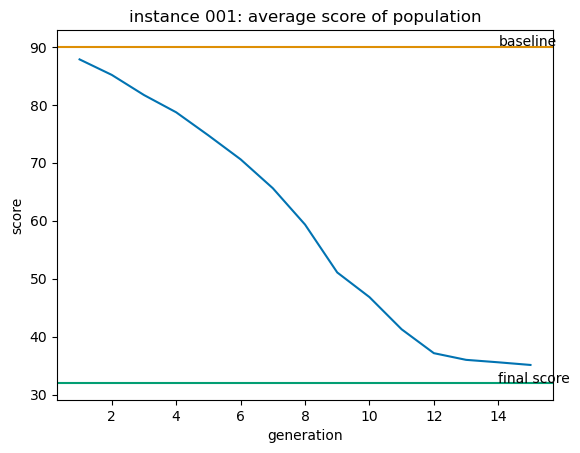

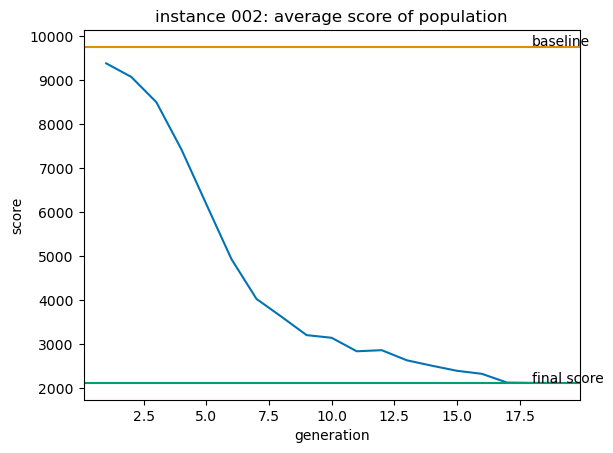

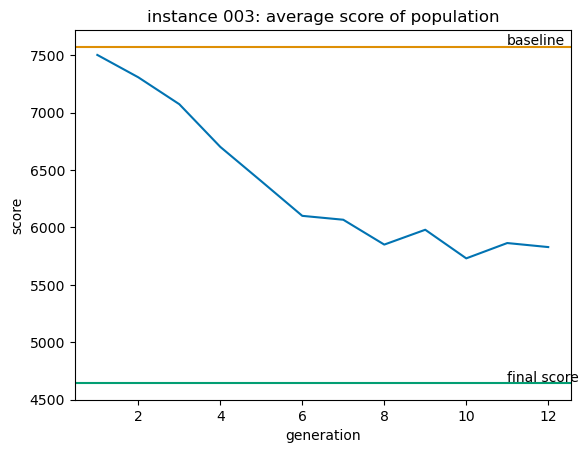

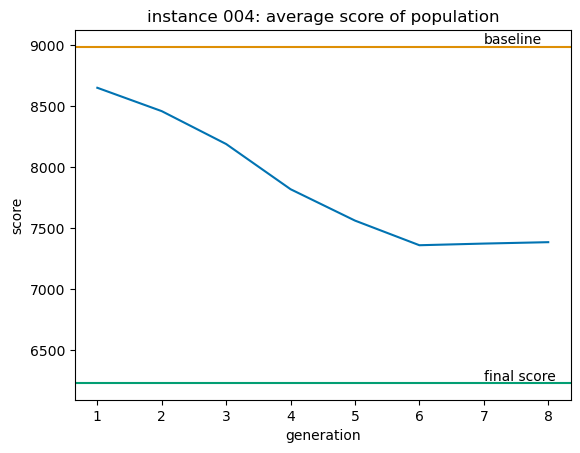

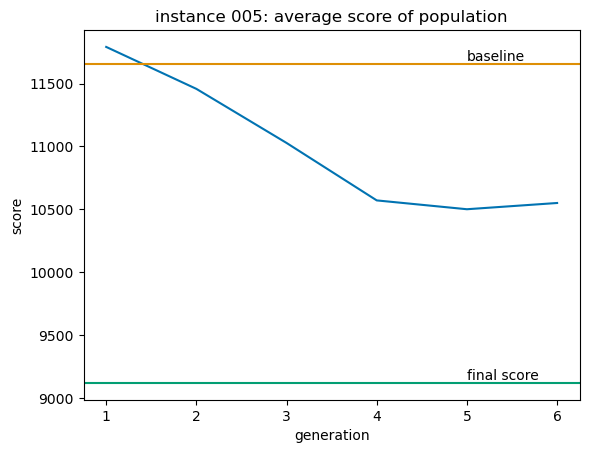

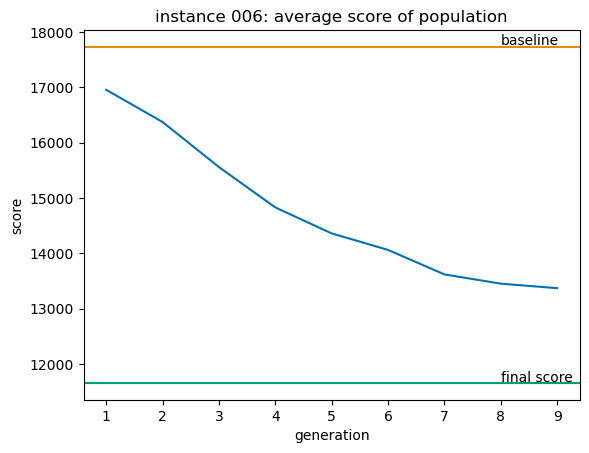

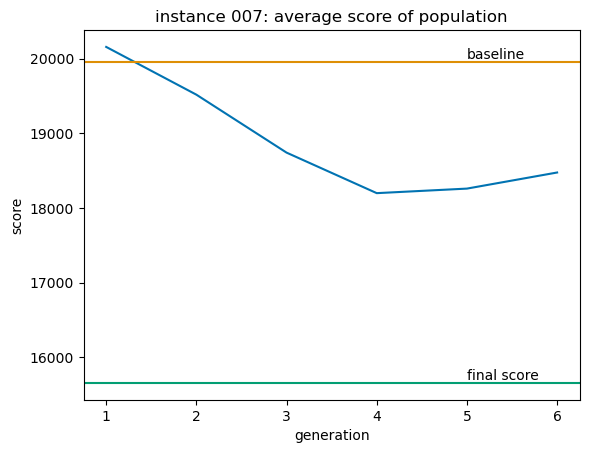

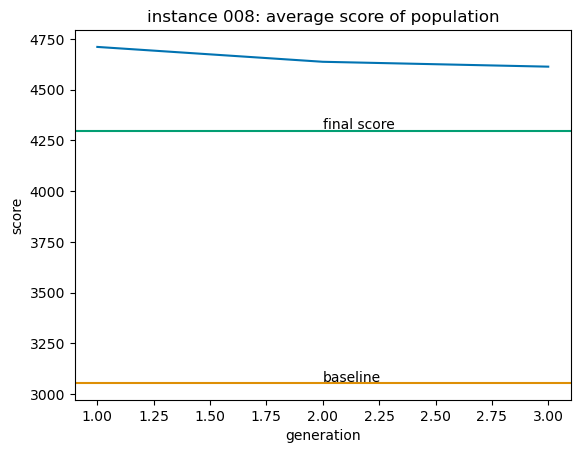

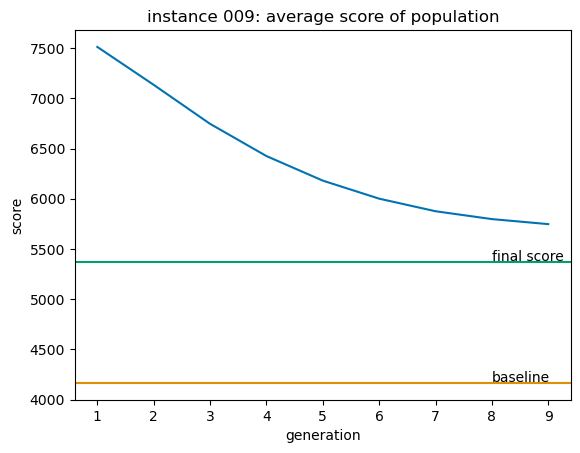

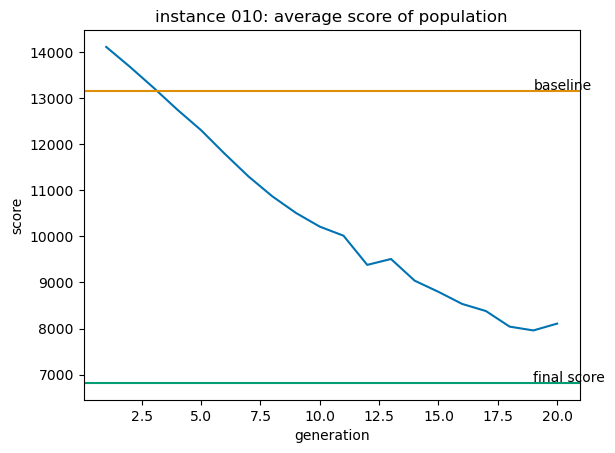

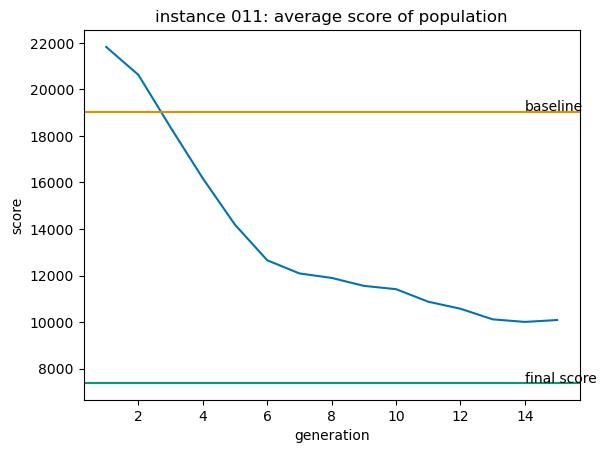

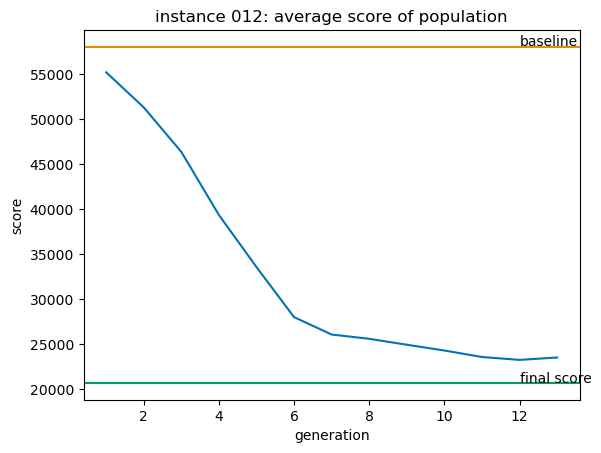

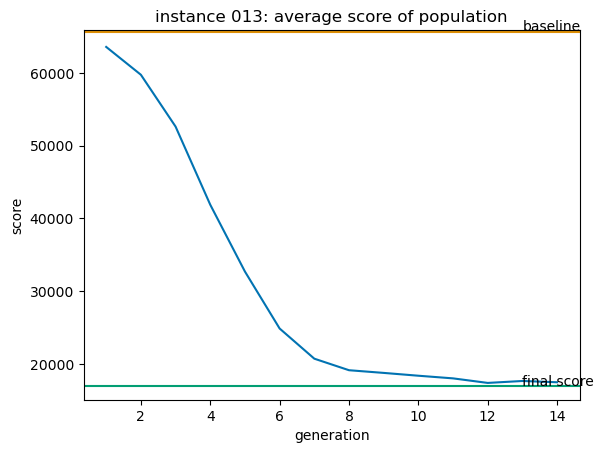

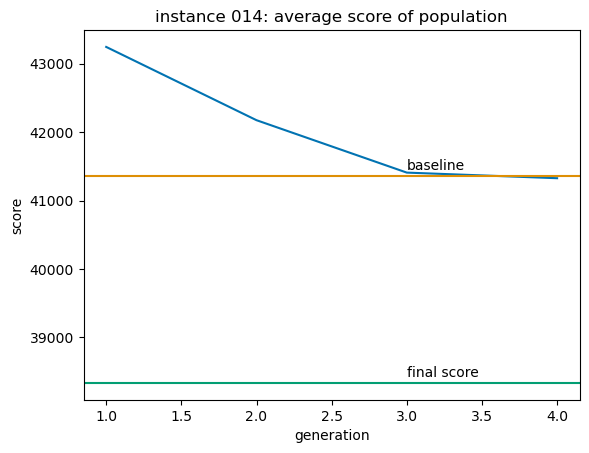

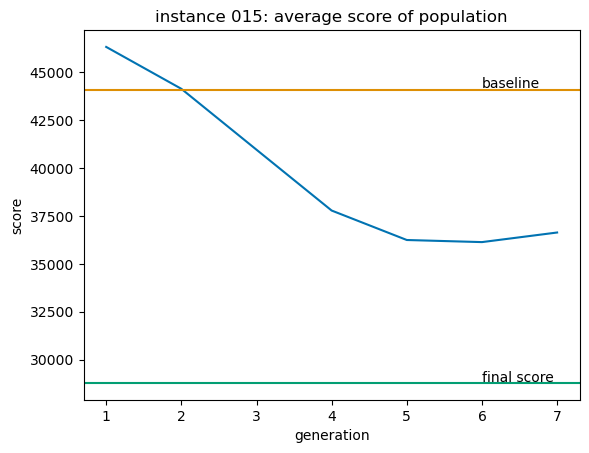

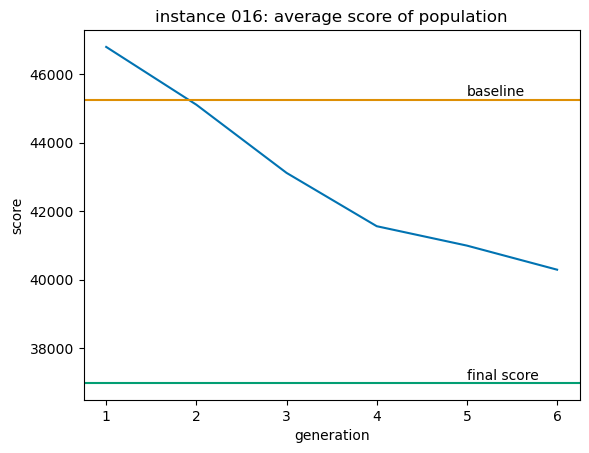

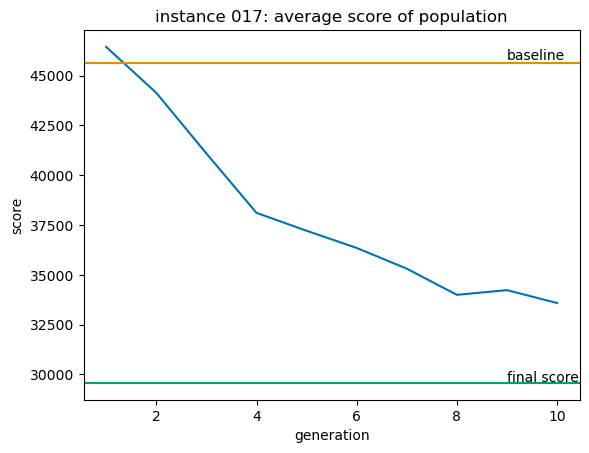

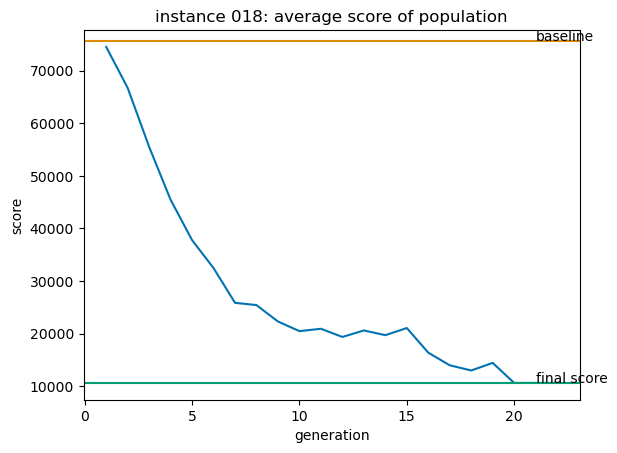

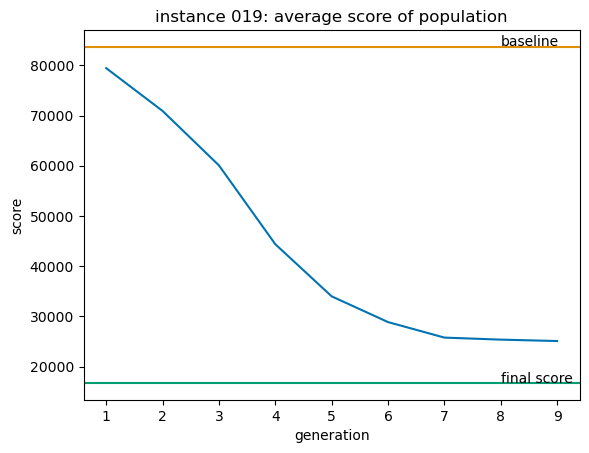

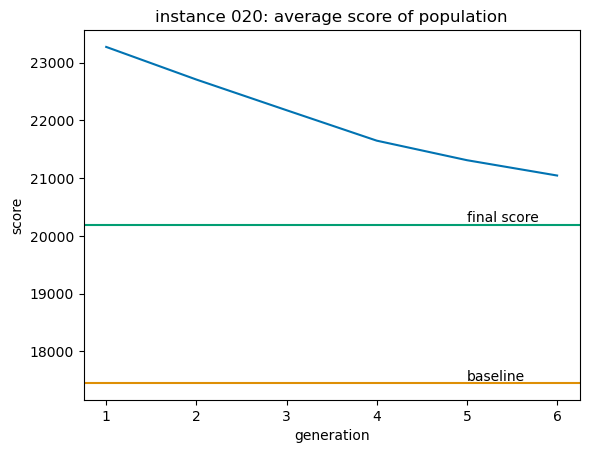

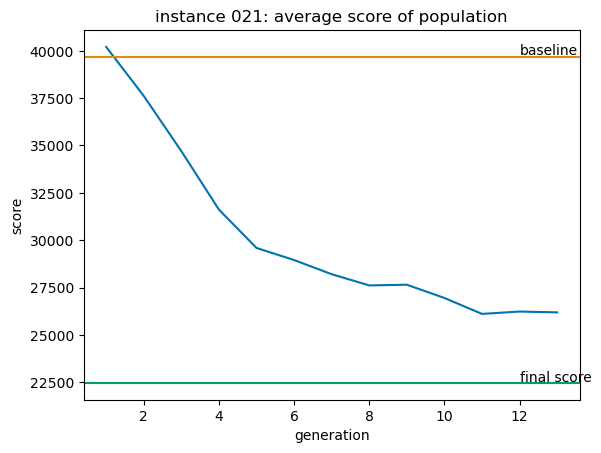

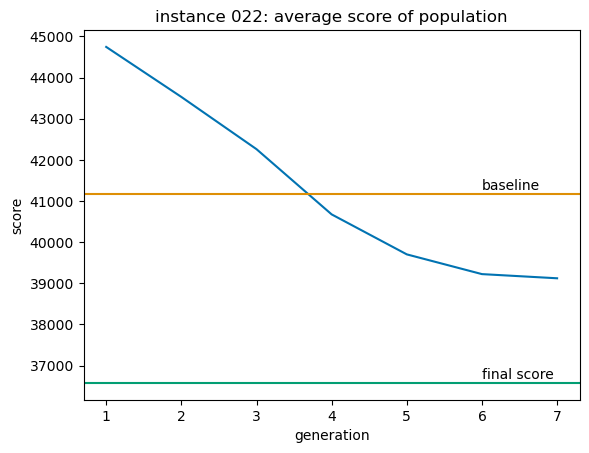

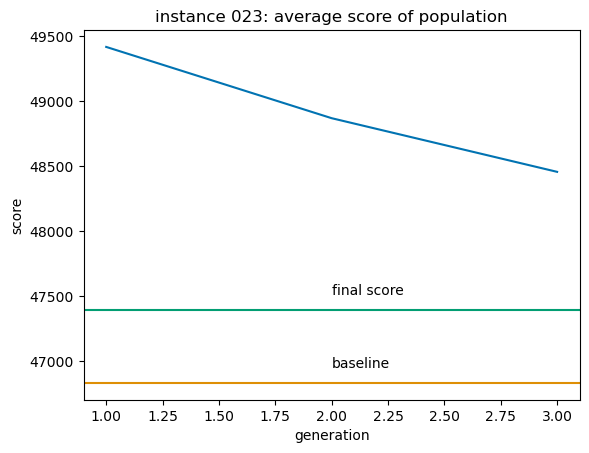

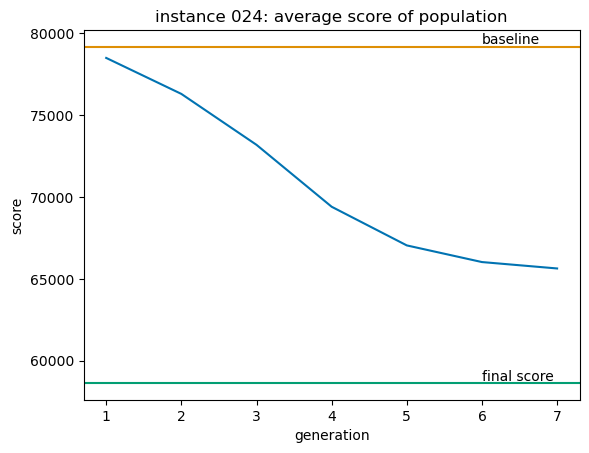

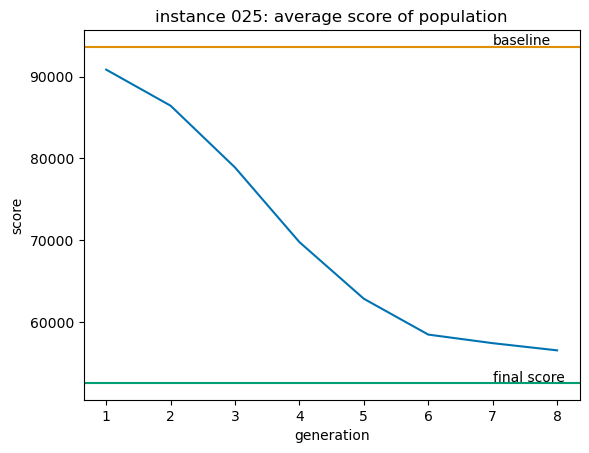

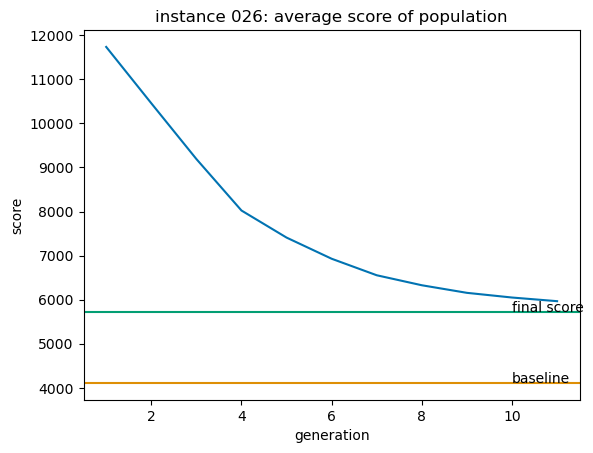

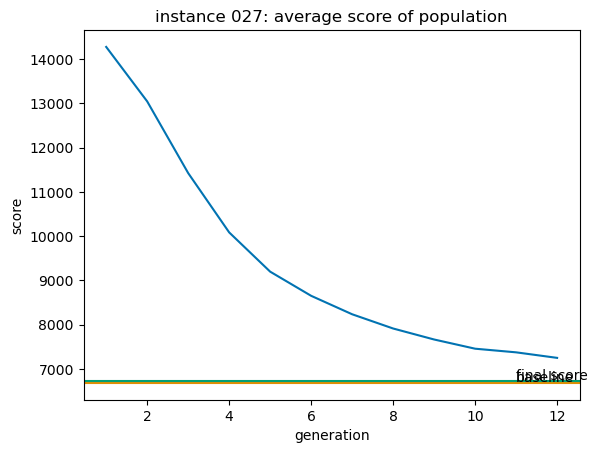

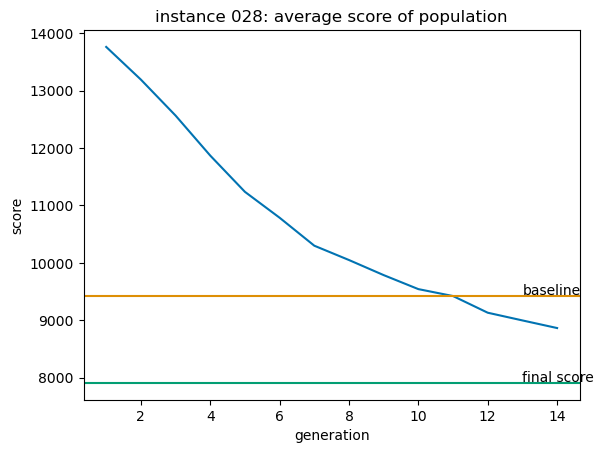

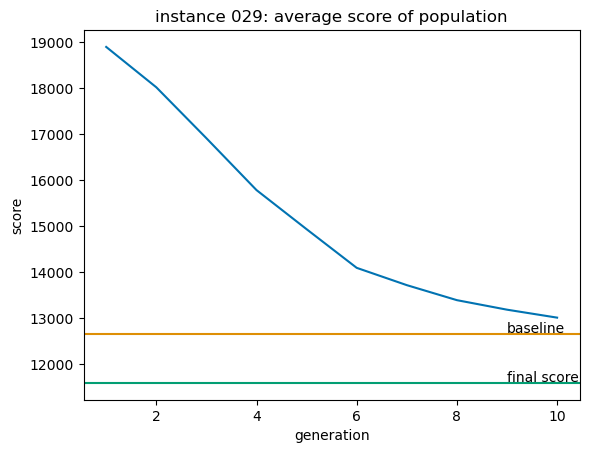

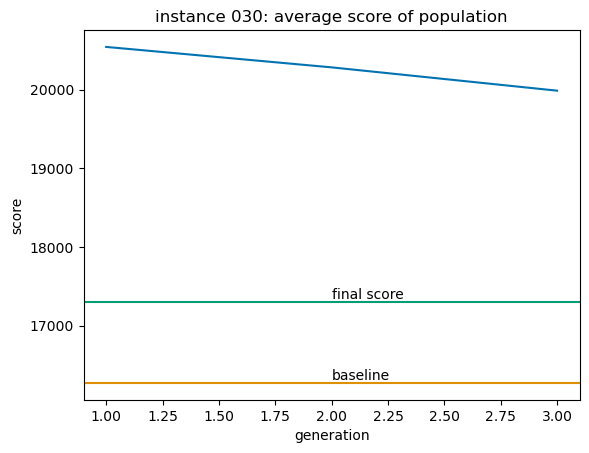

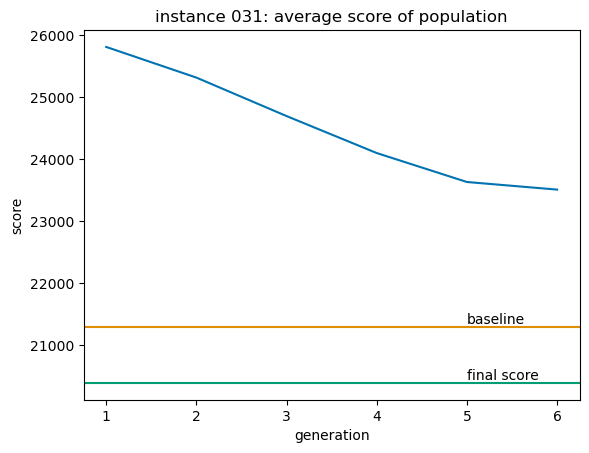

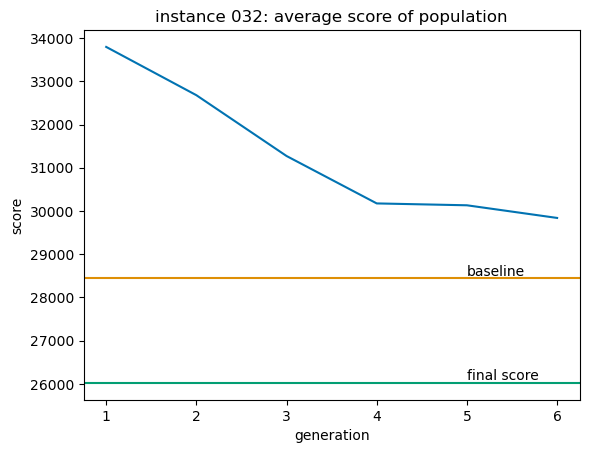

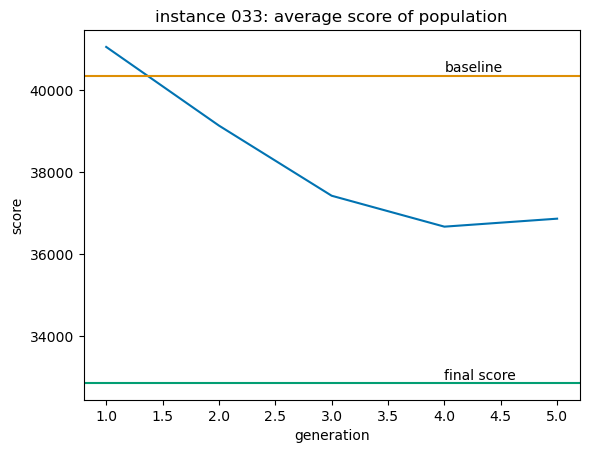

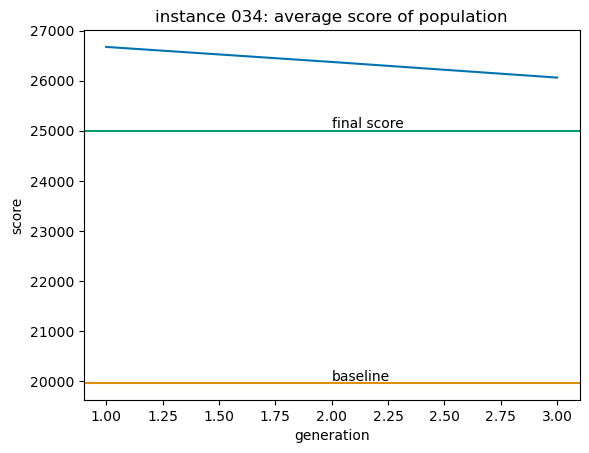

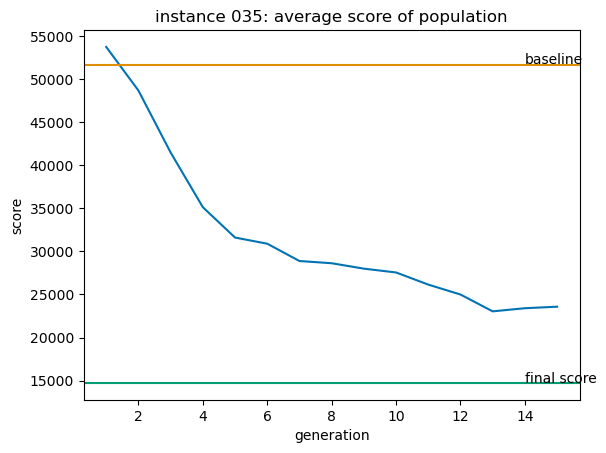

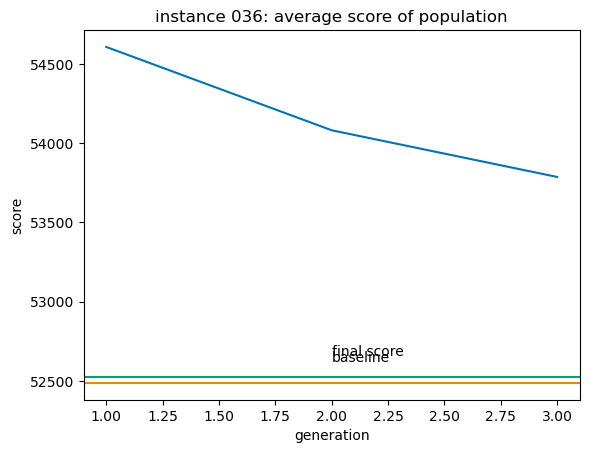

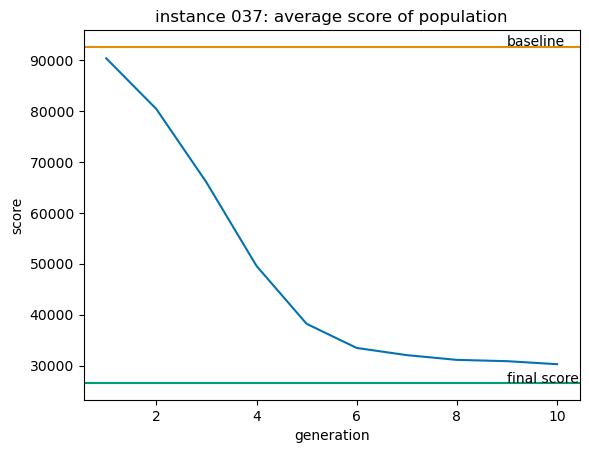

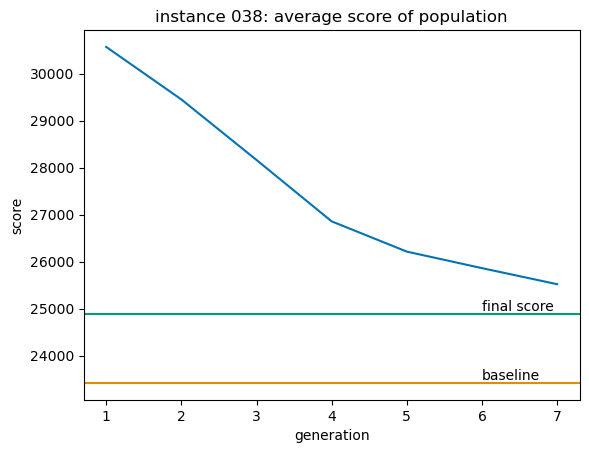

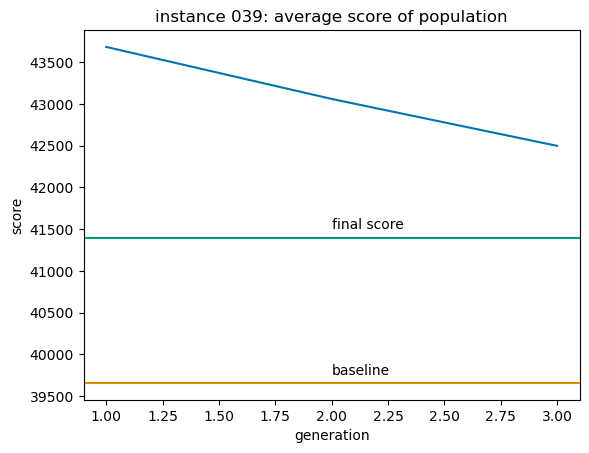

In [69]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
for inst_id in ga_results["instance_ID"]:
    baseline = ga_results["baseline"].loc[ga_results["instance_ID"]==inst_id].values[0]
    trajectory = ga_results["trajectory"].loc[ga_results["instance_ID"]==inst_id].values[0]
    final_score = ga_results["score"].loc[ga_results["instance_ID"]==inst_id].values[0]

    g = sns.lineplot(x=range(1,len(trajectory)+1), y=trajectory, color = '#0173b2')
    g.axhline(y = baseline,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = '#de8f05')
    g.annotate('baseline', xy = (len(trajectory)-1, baseline+baseline*0.0025))
    g.axhline(y = final_score,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = "#029e73", label = "test")
    g.annotate('final score', xy = (len(trajectory)-1, final_score+final_score*0.0025))
    g.set(xlabel='generation', ylabel='score')
    g.set_title("instance "+inst_id+': average score of population')
    
    plt.show()

### pick 2 interesting instances for the report

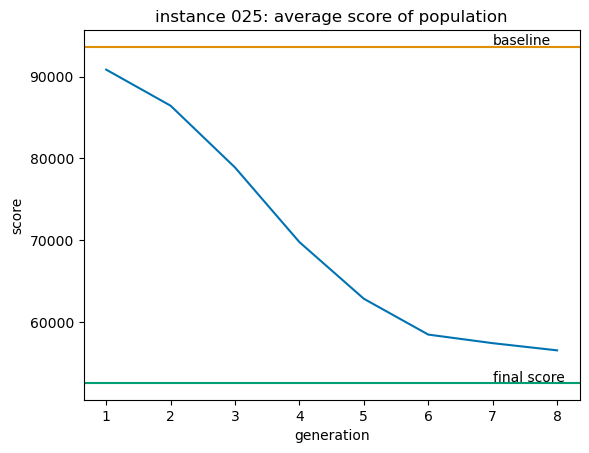

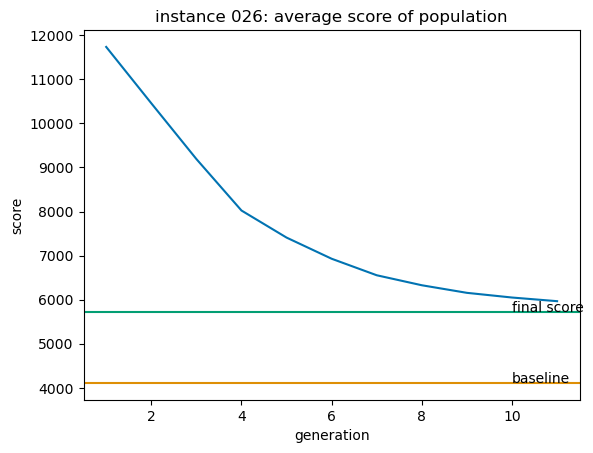

In [75]:
for inst_id in ["025", "026"]:
    baseline = ga_results["baseline"].loc[ga_results["instance_ID"]==inst_id].values[0]
    trajectory = ga_results["trajectory"].loc[ga_results["instance_ID"]==inst_id].values[0]
    final_score = ga_results["score"].loc[ga_results["instance_ID"]==inst_id].values[0]

    g = sns.lineplot(x=range(1,len(trajectory)+1), y=trajectory, color = '#0173b2')
    g.axhline(y = baseline,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = '#de8f05')
    g.annotate('baseline', xy = (len(trajectory)-1, baseline+baseline*0.0025))
    g.axhline(y = final_score,    # Line on y = 0.2
               xmin = 0, # From the left
               xmax = 1, color = "#029e73", label = "test")
    g.annotate('final score', xy = (len(trajectory)-1, final_score+final_score*0.0025))
    g.set_title("instance "+inst_id+': average score of population')
    g.set(xlabel='generation', ylabel='score')
    #
    plt.savefig("GA_"+inst_id+".png")
    plt.show()